# Accessing and Using OpenLandMap-soildb

This tutorial is designed to guide users through the process of accessing and working with **OpenLandMap-soildb**. It is divided into five parts:

1. **Brief introduction**  
   Overview of the OpenLandMap-soildb dataset, structure, and key features.

2. **Point query for soil property information and associated uncertainty**  
   How to extract soil property data for specific geographic points using the OpenLandMap-soildb maps, and how to inspect prediction uncertainty intervals associated with the soil property estimates.

3. **Time series analysis (2000–2022)**  
   Examine how soil properties have changed over time using the 5-year interval maps.

4. **Depth profile analysis**  
   Explore how soil properties vary with depth at specific locations.


## Brief introduction to OpenLandMap-soildb

### Comprehensive coverage

**OpenLandMap-soildb** is a global soil database that provides high-resolution (30 m) dynamic predictions of key soil properties using spatiotemporal machine learning. It includes the following soil variables:

- Soil organic carbon density \[kg/m³\]
- Soil organic carbon content \[g/kg\]
- Soil pH in H₂O \[-\]
- Bulk density (fine earth) \[kg/m³\]
- Soil texture fractions (clay, silt, sand) \[%\]
- USDA soil taxonomy subgroups \[-\]

**Soil organic carbon (SOC)** and **soil pH** are modeled at **5-year intervals**, while other properties (texture, bulk density, soil types) are mapped for recent years only.

### Open, reproducible mapping framework

The predictions are generated using **Tree-based Quantile Regression Random Forests**, trained on hundreds of thousands of globally distributed soil samples combined with remote sensing data (e.g., **Landsat**, **MODIS**, **Sentinel**). The production code is openly available on the [OpenLandMap-soildb GitHub repository](https://github.com/openlandmap/soildb).

### Openly available data

All maps are registered on **Zenodo** with a valid DOI: [10.5281/zenodo.15470431](https://doi.org/10.5281/zenodo.15470431), and are accessible under a **CC-BY license**.

Complete global mosaics at 30 m resolution are available via:

- [Google Earth Engine](https://code.earthengine.google.com/?asset=projects/global-pasture-watch/assets/gsm-30m)  
- [OpenLandMap STAC Browser](https://stac.openlandmap.org/)

### Example usage in python notebooks

In the following examples, we will demonstrate how to: access predictions and their associated uncertainties, analyze time-series data of SOC density, and explore depth variation of SOC, from selected locations. The **SOC density (SOCD)** maps will be used as the primary example throughout. Users could adapt this notebook easily to any other soil properties covered by OpenLandMap-soildb.


## Point query for soil property information

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.windows import Window
from rasterio.vrt import WarpedVRT

# sample coordinates: (longitude, latitude)
# define by users
points = [
    (116.19064,-0.01120),  # from Indonesian rainforest
    (91.32049,28.89395)    # from Tibetan plateau
]

# convert to geodataframe
# make sure to convert to EPSG:4326 to match with soil layers
gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in points], crs="EPSG:4326")


The data url can be found via the [OpenLandMap STAC Browser](https://stac.openlandmap.org/). Each dataset layer follows a standardized naming convention based on 10 key metadata fields:

1. **Generic variable name** – identifies the soil property (e.g., SOC, pH)  
2. **Variable–procedure combination** – indicates the derivation method and data source  
3. **Value type or distribution position** – e.g., mean, lower/upper quantile  
4. **Spatial support** – spatial resolution (30 m for all datasets in this study)  
5. **Depth reference** – denoted as *s*, indicating depth from the surface  
6. **Time reference** – includes start and end dates for temporal coverage  
7. **Bounding box ID** – labeled as *go* for global extent  
8. **EPSG code** – spatial reference system (EPSG:4326 used here)  
9. **Version code** – reflects the dataset’s creation date for version tracking  
10. **Other descriptors** – as needed for internal consistency

These metadata fields help users assess the dataset's relevance, resolution, depth, and time coverage for their specific application.

We will extract SOCD information from the topsoil layer (0–30 cm below ground) for the time interval 2000–2005.


In [2]:
base_path = 'http://192.168.1.30:8333/global-soil/global_soil_props_v20250204_mosaics'
socd_url = f"{base_path}/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204.tif"
p16_url = f"{base_path}/oc_iso.10694.1995.mg.cm3_p16_120m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204.tif"
p84_url = f"{base_path}/oc_iso.10694.1995.mg.cm3_p84_120m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204.tif"

In [3]:
# define a function to extract values
def extract_values(raster_url, gdf):
    with rasterio.open(raster_url) as src:
        gdf_proj = gdf.to_crs(src.crs)
        values = []
        for pt in gdf_proj.geometry:
            row, col = src.index(pt.x, pt.y)
            window = Window(col, row, 1, 1)
            data = src.read(1, window=window)
            value = data[0, 0]
            values.append(value)
    return values

# extract values from each raster
mean_vals = extract_values(socd_url, gdf)
p16_vals = extract_values(p16_url, gdf)
p84_vals = extract_values(p84_url, gdf)

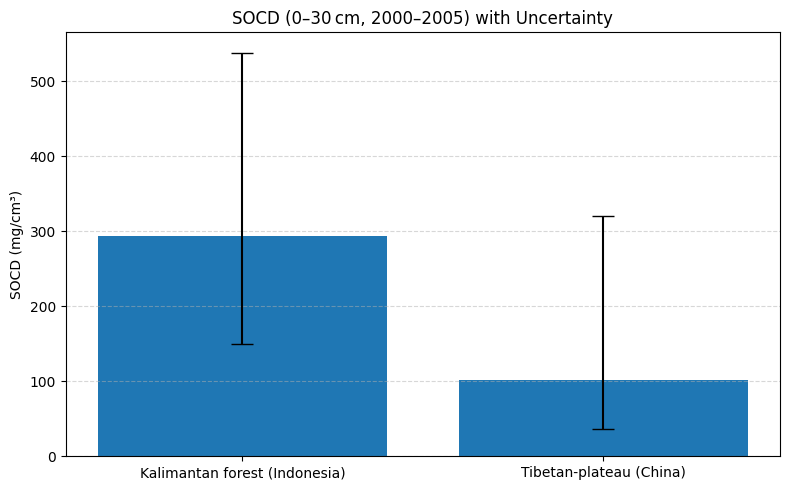

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# compute error bars (asymmetric)
lower_errors = [m - p16 for m, p16 in zip(mean_vals, p16_vals)]
upper_errors = [p84 - m for m, p84 in zip(mean_vals, p84_vals)]

# plotting
x_labels = ['Kalimantan forest (Indonesia)', 'Tibetan-plateau (China)']
x = np.arange(len(x_labels))

plt.figure(figsize=(8, 5))
plt.bar(x, mean_vals, yerr=np.array([lower_errors, upper_errors]), capsize=8)
plt.xticks(x, x_labels)
plt.ylabel("SOCD (mg/cm³)")
plt.title("SOCD (0–30 cm, 2000–2005) with Uncertainty")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Time sereis extraction and analysis

This analysis shows how **SOCD** changes over time at two locations:

- **Kalimantan forest (Indonesia)**
- **Tibetan Plateau (China)**


- SOCD data is extracted from raster layers for the topsoil (0–30 cm).
- Time periods: 2000–2005, 2005–2010, 2010–2015, 2015–2020, 2020–2022.
- For each location:
  - The **mean SOCD** is plotted over time.
  - The **P16–P84 percentile range** is shown as a shaded uncertainty band.



In [5]:
socd_urls = []
p16_urls = []
p84_urls = []

# time series of socd layers
time_intervals = ['20000101_20051231','20050101_20101231','20100101_20151231','20150101_20201231','20200101_20221231']

# we use top soil
for timei in time_intervals:
    socd_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_{timei}_g_epsg.4326_v20250204.tif")
    p16_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_p16_120m_b0cm..30cm_{timei}_g_epsg.4326_v20250204.tif")
    p84_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_p84_120m_b0cm..30cm_{timei}_g_epsg.4326_v20250204.tif")
    
mean_vals = []
p16_vals = []
p84_vals = []

for ii in range(len(time_intervals)):
    mean_vals.append(extract_values(socd_urls[ii], gdf))
    p16_vals.append(extract_values(p16_urls[ii], gdf))
    p84_vals.append(extract_values(p84_urls[ii], gdf))

mean_vals = np.array(mean_vals)
p16_vals = np.array(p16_vals)
p84_vals = np.array(p84_vals)

Each plot displays the SOCD trend and its uncertainty for one location.

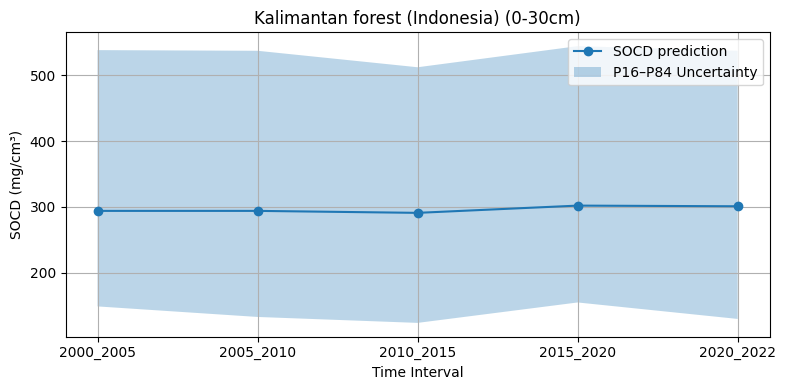

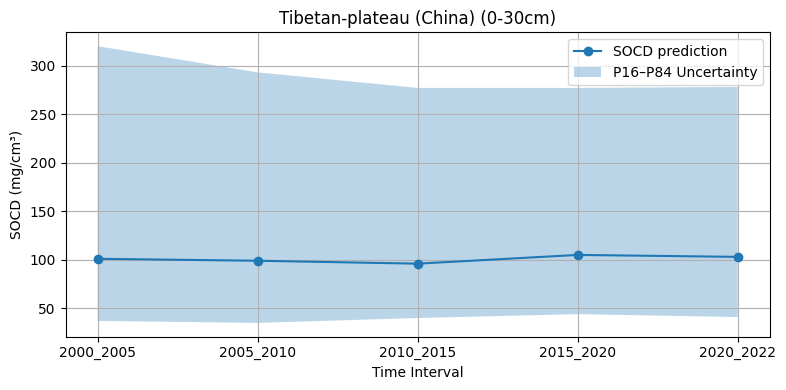

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# time axis labels
time_labels = ['2000_2005','2005_2010','2010_2015','2015_2020','2020_2022']
x = np.arange(len(time_labels))

num_points = mean_vals.shape[1]
point_labels = ['Kalimantan forest (Indonesia)', 'Tibetan-plateau (China)']

for i in range(num_points):
    mean_series = mean_vals[:, i]
    lower = mean_series - p16_vals[:, i]
    upper = p84_vals[:, i] - mean_series

    plt.figure(figsize=(8, 4))
    plt.plot(x, mean_vals[:, i], marker='o', label=f"SOCD prediction")
    plt.fill_between(x, p16_vals[:, i], p84_vals[:, i], alpha=0.3, label="P16–P84 Uncertainty")
    plt.xticks(x, time_labels)
    plt.ylabel("SOCD (mg/cm³)")
    plt.xlabel("Time Interval")
    plt.title(f"{point_labels[i]} (0-30cm)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



## Plotting SOCD Variation with Depth

Extract SOCD values from different depth interval.


In [7]:
socd_urls = []
p16_urls = []
p84_urls = []

# depth series of socd layers
depth_intervals = ['b0cm..30cm','b30cm..60cm','b60cm..100cm']

for depthi in depth_intervals:
    socd_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_m_30m_{depthi}_20000101_20051231_g_epsg.4326_v20250204.tif")
    p16_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_p16_120m_{depthi}_20000101_20051231_g_epsg.4326_v20250204.tif")
    p84_urls.append(f"{base_path}/oc_iso.10694.1995.mg.cm3_p84_120m_{depthi}_20000101_20051231_g_epsg.4326_v20250204.tif")
    
mean_vals = []
p16_vals = []
p84_vals = []

for ii in range(len(depth_intervals)):
    mean_vals.append(extract_values(socd_urls[ii], gdf))
    p16_vals.append(extract_values(p16_urls[ii], gdf))
    p84_vals.append(extract_values(p84_urls[ii], gdf))

mean_vals = np.array(mean_vals)
p16_vals = np.array(p16_vals)
p84_vals = np.array(p84_vals)


This plot shows how Soil Organic Carbon Density (SOCD) varies with depth for selected points.

The total SOC stock at each point is calculated by summing SOCD values across depth intervals for that location. To estimate the SOC stock over a larger area, simply multiply the per-pixel stock by the pixel area (e.g., 30m × 30m = 900 m² per pixel).

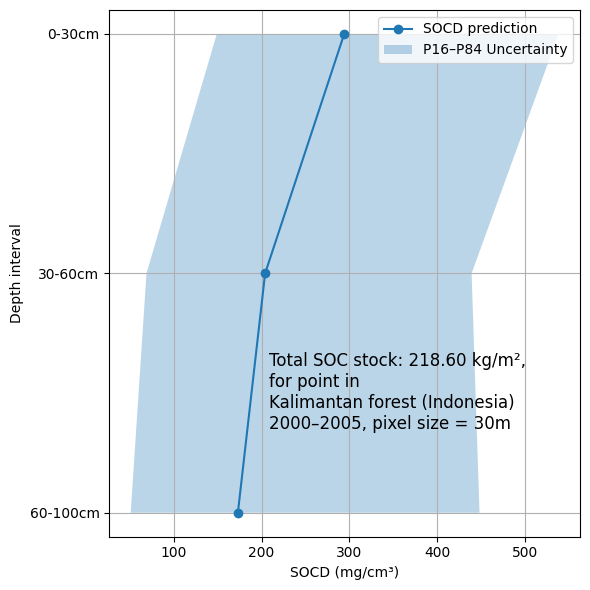

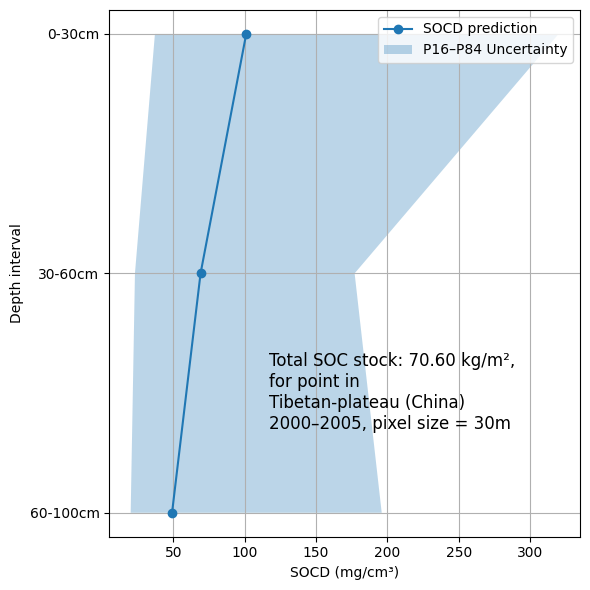

In [8]:
# depth axis labels
depth_labels = ['0-30cm','30-60cm','60-100cm']
x = np.arange(len(depth_labels))

# x = np.array([15, 45, 80])

num_points = mean_vals.shape[1]

for i in range(num_points):
    
    # calculate SOC stock
    stock = mean_vals[0, i]*0.3 + mean_vals[1, i]*0.3 + mean_vals[2, i]*0.4
    

    plt.figure(figsize=(6, 6))
    plt.plot(mean_vals[:, i], x, marker='o', label="SOCD prediction")
    plt.fill_betweenx(x, p16_vals[:, i], p84_vals[:, i], alpha=0.3, label="P16–P84 Uncertainty")
    plt.yticks(x, depth_labels)
    plt.gca().invert_yaxis()  # depth increases downward
    plt.xlabel("SOCD (mg/cm³)")
    plt.ylabel("Depth interval")
    # plt.title(f"Point {i + 1} (2000–2005)")
    plt.grid(True)
    plt.legend()
    
    plt.text(
        0.34, 0.35, 
        f"Total SOC stock: {stock:.2f} kg/m²,\nfor point in \n{point_labels[i]}\n2000–2005, pixel size = 30m",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top'
    )

    plt.tight_layout()
    plt.show()